## Análisis de Opiniones y Características de Listados de Airbnb en Ciudad México

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import nltk
import joblib
import importlib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import textfunctions
import plots
from wordcloud import WordCloud
# importlib.reload(textfunctions)

[nltk_data] Downloading package stopwords to /home/tux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tux/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/tux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
importlib.reload(textfunctions)

[nltk_data] Downloading package stopwords to /home/tux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tux/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/tux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'textfunctions' from '/home/tux/airbnb_comments/textfunctions.py'>

### 1. Carga de los datos y exploración inicial
- Cargamos los datos de Airbnb y realizamos una exploración inicial para entender la estructura y el contenido de los datos.
- Minimizamos el uso de memoria al cargar los datos, eliminando columnas innecesarias.
- Exploramos la columna objetivo: `review_scores_rating`.
- Eliminamos los items sin puntuación.
- Combinamos los datasets de listings y reviews
- Eliminamos los reviews que no estén en inglés
- Realizamos el etiquetado binario.
- Visualizamos la distribución de la nueva columna `target`.

In [3]:
df_listings = pd.read_csv('data/listings.csv')
print("Listings cargados:", df_listings.shape)
print("Columnas en listings:", df_listings.columns.tolist())

Listings cargados: (26067, 79)
Columnas en listings: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_

In [4]:
col_list_min = ['id', "review_scores_rating"]

In [5]:
df_listings = df_listings[col_list_min]
print("Listings cargados:", df_listings.shape)
print("Columnas en listings:", df_listings.columns.tolist())

Listings cargados: (26067, 2)
Columnas en listings: ['id', 'review_scores_rating']


In [6]:
print("Valores nulos en la variable objetivo: ",df_listings['review_scores_rating'].isnull().sum())
df_listings_clean = df_listings.dropna(subset=['review_scores_rating'])
print("Valores nulos en la variable objetivo después de eliminar: ",df_listings_clean['review_scores_rating'].isnull().sum())
print("Listings:", df_listings_clean.shape)

Valores nulos en la variable objetivo:  3261
Valores nulos en la variable objetivo después de eliminar:  0
Listings: (22806, 2)


In [7]:
df_reviews = pd.read_csv('data/reviews.csv')
print("Reviews cargados:", df_reviews.shape)
print("Columnas en reviews:", df_reviews.columns.tolist())

Reviews cargados: (1315986, 6)
Columnas en reviews: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']


In [8]:
col_reviews = ['listing_id', 'comments']

In [9]:
df_reviews = df_reviews[col_reviews]
print("Tamaño de df_reviews:", df_reviews.shape)

Tamaño de df_reviews: (1315986, 2)


La cantidad de reviews es muy grande, pero no todos están en inglés. Nos enfocaremos en los que están en inglés para simplificar el análisis.
Combinaremos los dos dataframes y luego con una librería externa clasificaremos el idioma de cada review.

In [10]:
df_merged = pd.merge(df_listings_clean, df_reviews, left_on='id', right_on='listing_id', how='inner')
print("Dataset combinado:", df_merged.shape)

Dataset combinado: (1315986, 4)


In [11]:
df_merged_lang = df_merged.copy()
df_merged_lang["comment_language"] = df_merged_lang["comments"].apply(textfunctions.detect_language)

In [12]:
print(df_merged_lang["comment_language"].value_counts())
print(df_merged_lang["comment_language"].value_counts(normalize=True) * 100)

comment_language
es         789738
en         474135
pt          11076
fr          10831
unknown     10656
            ...  
nap             1
sco             1
pam             1
be              1
az              1
Name: count, Length: 74, dtype: int64
comment_language
es         60.011125
en         36.028879
pt          0.841650
fr          0.823033
unknown     0.809735
             ...    
nap         0.000076
sco         0.000076
pam         0.000076
be          0.000076
az          0.000076
Name: proportion, Length: 74, dtype: float64


In [13]:
df_reviews_en = df_merged_lang[df_merged_lang["comment_language"].isin(["en"])].copy()

Eliminamos la columna `comment_language`, ya que no la utilizaremos en el análisis.

In [14]:
df_reviews_en = df_reviews_en.drop(columns=["comment_language"])

In [15]:
df_reviews_en.shape

(474135, 4)

In [16]:
lim_inf = 3.9
lim_sup = 5.0

In [17]:
df_filtered_reviews = df_reviews_en[~df_reviews_en["review_scores_rating"].between(lim_inf, lim_sup, inclusive="left")].copy()
df_filtered_reviews["target"] = (df_filtered_reviews["review_scores_rating"] > 4.5).astype(int)

In [18]:
print(df_filtered_reviews["target"].value_counts())

target
1    11709
0      420
Name: count, dtype: int64


/tmp/ipykernel_5143/3585192853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered_reviews, x='target', palette='viridis')


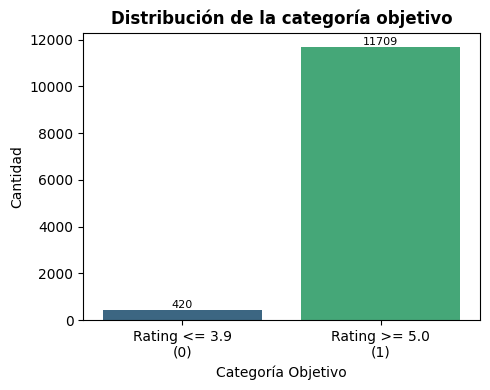

In [19]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df_filtered_reviews, x='target', palette='viridis')

# Add labels and title
plt.title('Distribución de la categoría objetivo', fontsize=12, fontweight='bold')
plt.xlabel('Categoría Objetivo', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)

# Add value labels on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.xticks([0, 1], [f'Rating <= {lim_inf}\n(0)', f'Rating >= {lim_sup}\n(1)'])

# Adjust layout and display
plt.tight_layout()
plt.show()

Notamos que hay un gran desbalance en la categoría objetivo. Esto será algo importante a tener en cuenta al momento de elegir, entrenar y evaluar los modelos.

## 2. Preprocesamiento del texto
- Eliminamos las filas con valores nulos.
- Eliminamos caracteres especiales, números y stopwords.
- Convertimos todo a minúsculas.
- Realizamos lematización para reducir las palabras a su forma base.
- Creamos una nueva columna en el dataframe de reviews con el texto preprocesado.
- Creamos dataframes nuevos para cada clase.
- Aplicamos un vectorizador para cada clase.
- Obtenemos un wordcloud por clase.

Utilizaremos la columna `comments` del dataframe de reviews para el análisis, ya que está nos ayudará a entender mejor las opiniones de los usuarios que son quienes hacen las reseñas.

In [20]:
print("Reseñas sin comentarios: ",df_filtered_reviews['comments'].isnull().sum())

Reseñas sin comentarios:  0


In [21]:
df_filtered_reviews["clean_comments"] = df_filtered_reviews["comments"].apply(textfunctions.clean_text)

In [22]:
df_filtered_reviews["lemmatized"] = df_filtered_reviews["clean_comments"].apply(textfunctions.lemmatize_text)

In [23]:
df_filtered_reviews["processed_comments"] = df_filtered_reviews["lemmatized"].apply(textfunctions.remove_stopwords)

In [24]:
print(df_filtered_reviews["target"].value_counts())

target
1    11709
0      420
Name: count, dtype: int64


In [25]:
df_filtered_reviews.to_parquet(
    "data/processed_comments.parquet", 
    engine='pyarrow', 
    compression='snappy',
    index=False)

In [26]:
df_filtered_reviews.columns.to_list()
print("Columnas del DataFrame procesado:", df_filtered_reviews.columns.tolist())

Columnas del DataFrame procesado: ['id', 'review_scores_rating', 'listing_id', 'comments', 'target', 'clean_comments', 'lemmatized', 'processed_comments']


In [27]:
cols = ['id', 'review_scores_rating', 'listing_id', 'processed_comments', 'target']
df_processed_reviews = pd.read_parquet(
    "data/processed_comments.parquet",
    engine='pyarrow',
    columns=cols
)

/home/tux/airbnb_comments/plots.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis", ax=ax)


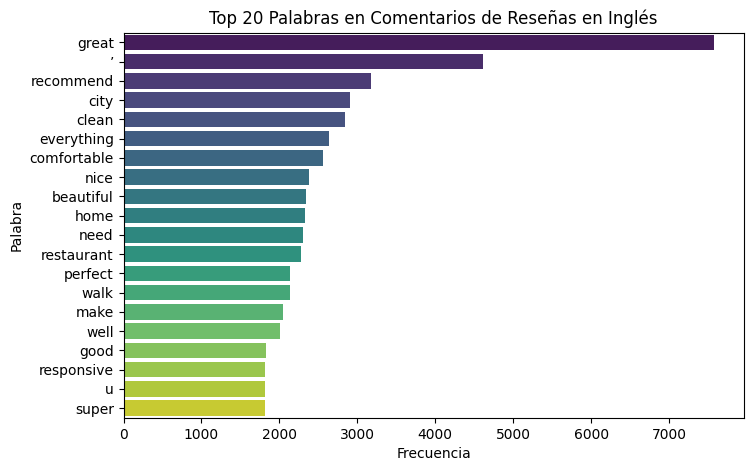

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
plots.plot_top_words(df_processed_reviews, "processed_comments", top_n=20, ax=ax, title="Top 20 Palabras en Comentarios de Reseñas en Inglés",)
plt.show()

Vectorización
Para la vectorización del texto, utilizaremos TF-IDF (Term Frequency-Inverse Document Frequency) para convertir el texto preprocesado en vectores numéricos que puedan ser utilizados por los modelos de machine learning.

En esta parte, como se vectorizara basándonos en las clases, crearemos un dataframe para cada clase.

In [29]:
text_col = 'processed_comments'
label_col = 'target'

df_pos = df_processed_reviews[df_processed_reviews[label_col] == 1].copy()
df_neg = df_processed_reviews[df_processed_reviews[label_col] == 0].copy()

In [ ]:
common_params = {
    'max_df': 0.90,
    'min_df': 0.02,
    'ngram_range': (1, 2),
    'stop_words': stopwords.words('english')
}

vectorizer_global = TfidfVectorizer(**common_params)
vectorizer_global.fit(df_processed_reviews[text_col])

# Transformamos cada clase por separado
df_pos = df_processed_reviews[df_processed_reviews[label_col] == 1]
df_neg = df_processed_reviews[df_processed_reviews[label_col] == 0]

tfidf_pos = vectorizer_global.transform(df_pos[text_col])
tfidf_neg = vectorizer_global.transform(df_neg[text_col])

# Extraemos el vocabulario global
features = vectorizer_global.get_feature_names_out()

# Sumamos TF–IDF por término en cada clase
sums_pos = np.asarray(tfidf_pos.sum(axis=0)).ravel()
sums_neg = np.asarray(tfidf_neg.sum(axis=0)).ravel()

# Obtenemos índices ordenados de mayor a menor peso
idx_sorted_pos = np.argsort(sums_pos)[::-1]
idx_sorted_neg = np.argsort(sums_neg)[::-1]

# Creamos las listas para alta y baja calificación
top_pos = [(features[i], float(sums_pos[i])) for i in idx_sorted_pos[:10]]
top_neg = [(features[i], float(sums_neg[i])) for i in idx_sorted_neg[:10]]

print("Top 10 términos (alta calif):", top_pos)
print("Top 10 términos (baja calif):", top_neg)


Top 10 términos (alta calif): [('great', 1250.7377760761842), ('recommend', 549.4303185699617), ('nice', 522.6401195205045), ('clean', 516.7761958947912), ('beautiful', 476.1593889392082), ('everything', 469.9463931858028), ('city', 460.86711884994776), ('perfect', 444.6089913327924), ('comfortable', 439.5960349394776), ('good', 400.36481968695443)]
Top 10 términos (baja calif): [('great', 35.08781327811925), ('good', 30.802945521830466), ('water', 21.867127114139905), ('nice', 19.725574201985214), ('get', 19.460078174956518), ('day', 17.327021672664603), ('night', 15.316498422874254), ('work', 15.187979727450754), ('one', 14.729415053591325), ('time', 14.650131293930944)]


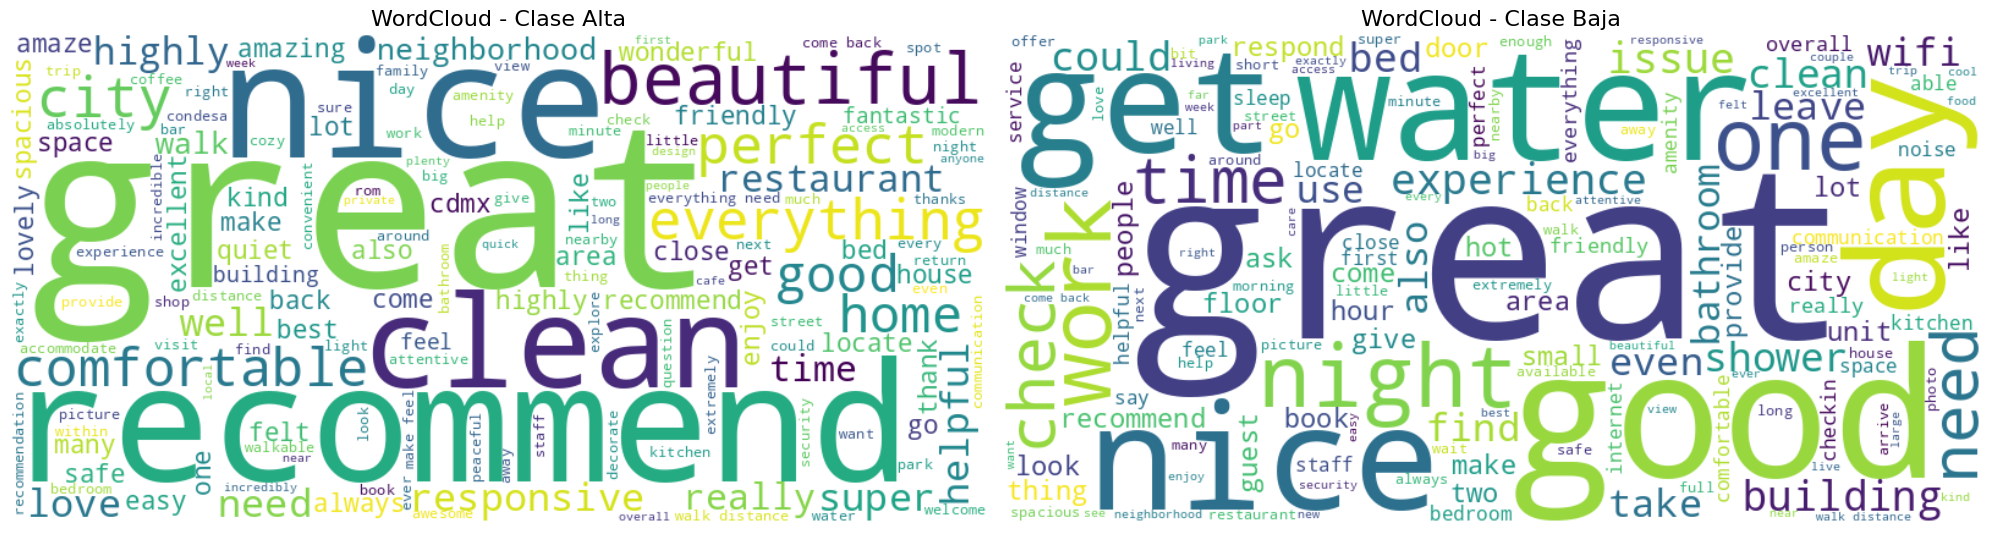

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

plots.plot_wordcloud_from_matrix(
    tfidf_pos,
    features,
    top_n=100,
    title="WordCloud - Clase Alta",
    ax=ax1
)

plots.plot_wordcloud_from_matrix(
    tfidf_neg,
    features,
    top_n=100,
    title="WordCloud - Clase Baja",
    ax=ax2
)

plt.tight_layout()
plt.show()